In [2]:
import pandas as pd
import numpy as np
import json

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### FUNCIONES

In [3]:
def cost(Y, X, T):
    return(((X @ T.T - Y) ** 2) * ((Y != 0) * 1)).sum()


def gradient(Y, X, T):
    R = (Y != 0) * 1
    hip_error = (X @ T.T - Y) * R

    return (
        hip_error @ T,
        hip_error.T @ X,
    )


def adam(
        Y,
        Xo,
        To,
        fun,
        jac,
        alpha=0.001,
        beta1=0.9,
        beta2=0.999,
        epsilon=0.0000001,
        max_iter=1000
):
    xm = np.zeros(Xo.shape)
    tm = np.zeros(To.shape)

    xv = np.zeros(Xo.shape)
    tv = np.zeros(To.shape)

    X, T, t = Xo, To, 0

    while t < max_iter:
        t += 1

        xg, tg = jac(Y, X, T)

        #print(f'{t} \t loss={fun(Y, X, T).item():,.2f}')

        xm = beta1 * xm + (1 - beta1) * xg
        tm = beta1 * tm + (1 - beta1) * tg

        xv = beta2 * xv + (1 - beta2) * xg * xg
        tv = beta2 * tv + (1 - beta2) * tg * tg

        xmh = xm / (1 - beta1 ** t)
        tmh = tm / (1 - beta1 ** t)

        xvh = xv / (1 - beta2 ** t)
        tvh = tv / (1 - beta2 ** t)

        X -= alpha * xmh / (np.sqrt(xvh) + epsilon)
        T -= alpha * tmh / (np.sqrt(tvh) + epsilon)

    return X, T

### UPLOAD DATA

In [4]:
links = pd.read_csv('/Users/maria/OneDrive/Documentos/mle_laboratorios/Lab7/Lab7/links_small.csv')
movies = pd.read_csv('/Users/maria/OneDrive/Documentos/mle_laboratorios/Lab7/Lab7/movies_metadata.csv')
ratings = pd.read_csv('/Users/maria/OneDrive/Documentos/mle_laboratorios/Lab7/Lab7/ratings_small.csv')

print(links.shape, movies.shape, ratings.shape)

(9125, 3) (45466, 24) (100004, 4)


In [5]:
print("Links:\n", links.dtypes, "\nMovies:\n", movies.dtypes, "\nRatings:\n", ratings.dtypes)

Links:
 movieId      int64
imdbId       int64
tmdbId     float64
dtype: object 
Movies:
 adult                     object
belongs_to_collection     object
budget                    object
genres                    object
homepage                  object
id                        object
imdb_id                   object
original_language         object
original_title            object
overview                  object
popularity                object
poster_path               object
production_companies      object
production_countries      object
release_date              object
revenue                  float64
runtime                  float64
spoken_languages          object
status                    object
tagline                   object
title                     object
video                     object
vote_average             float64
vote_count               float64
dtype: object 
Ratings:
 userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: obj

In [6]:
# Union de movieID en con ratings y usuarios con imbdID y tmbdID en links
df = ratings.join(links, rsuffix='_r', how='inner', on = 'movieId')
df = df[['userId', 'movieId', 'rating', 'imdbId', 'tmdbId']]
df.head()

,userId,movieId,rating,imdbId,tmdbId
0,1,31,2.5,114746,63.0
498,7,31,3.0,114746,63.0
6059,31,31,4.0,114746,63.0
6130,32,31,4.0,114746,63.0
6526,36,31,3.0,114746,63.0


In [7]:
#Prueba de funcion de pivot para unificar las peliculas y usuarios
y = df.pivot(index='movieId',columns='userId',values='rating')
y.head()

userId,1,2,3,4,5,6,7,8,9,10,...,662,663,664,665,666,667,668,669,670,671
movieId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,4.0,NaN,...,NaN,4.0,3.5,NaN,NaN,NaN,NaN,NaN,4.0,5.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
movies.rename(columns={'imdb_id': 'imdbId'}, inplace=True)
movies.rename(columns={'id': 'tmdbId'}, inplace=True)
movies.head()

,adult,belongs_to_collection,budget,genres,homepage,tmdbId,imdbId,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


### VARIABLES JSON

In [9]:
movies['genres'][0]

"[{'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}, {'id': 10751, 'name': 'Family'}]"

In [10]:
movies['genres'] = movies['genres'].str.replace("\'","\"")
unjson = ['genres']

def fun1(x):
    return json.loads(x)

for i in unjson:
    movies[i] = movies[i].apply(fun1)


def fun2(x):
    a = []
    for y in range(len(x[0])):
        for k, v in x[0][y].items():
            a.append(str(k)+ "_" +str(v))
    for j in range(len(a)):
        if a[j] not in df.columns:
            df[a[j]] = 0
            df[a[j]].iloc[x.name] = 1
        else:
            df[a[j]].iloc[x.name] = 1
    return

for i in unjson:
    movies[[i]].apply(fun2, axis=1)

In [11]:
a = pd.to_numeric(movies['tmdbId'], errors = 'coerce')
movies = movies.assign(tmdbId=a)

In [12]:
df1 = movies.join(df, rsuffix='_r', how='inner', on = 'tmdbId')
df1.shape

(24943, 93)

In [13]:
df1.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'tmdbId', 'imdbId', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count', 'userId', 'movieId', 'rating', 'imdbId_r',
       'tmdbId_r', 'id_16', 'name_Animation', 'id_35', 'name_Comedy',
       'id_10751', 'name_Family', 'id_12', 'name_Adventure', 'id_14',
       'name_Fantasy', 'id_10749', 'name_Romance', 'id_18', 'name_Drama',
       'id_28', 'name_Action', 'id_80', 'name_Crime', 'id_53', 'name_Thriller',
       'id_27', 'name_Horror', 'id_36', 'name_History', 'id_878',
       'name_Science Fiction', 'id_9648', 'name_Mystery', 'id_10752',
       'name_War', 'id_10769', 'name_Foreign', 'id_10402', 'name_Music',
       'id_99', 'name_Documentary', 'id_37', 'name_Western', 'id_10770'

### SEPARACION VARIABLES X Y Y

In [14]:
df1 = df1.sort_values(by=['movieId'])
equis = df1.filter(regex = ("^name"))
equis.shape

(24943, 32)

In [15]:
equis = pd.concat([df1['movieId'], equis], axis = 1)
x = pd.pivot_table(equis, index='movieId',aggfunc='mean')
print(x.head(), x.shape)

         name_Action  name_Adventure  name_Animation  name_Aniplex  \
movieId                                                              
1           0.324675        0.064935        0.077922             0   
2           0.212121        0.090909        0.030303             0   
3           0.117647        0.176471        0.058824             0   
4           0.000000        0.000000        0.000000             0   
5           0.172414        0.000000        0.137931             0   

         name_BROSTA TV  name_Carousel Productions  name_Comedy  name_Crime  \
movieId                                                                       
1                     0                        0.0     0.389610    0.090909   
2                     0                        0.0     0.272727    0.060606   
3                     0                        0.0     0.352941    0.117647   
4                     0                        0.0     0.000000    0.000000   
5                     0            

In [16]:
df1['generos']= df1[['name_Animation', 'name_Comedy', 'name_Family', 'name_Adventure', 'name_Fantasy', 'name_Romance', 'name_Drama', 'name_Action', 'name_Crime', 'name_Thriller',
       'name_Horror', 'name_History', 'name_Science Fiction', 'name_Mystery', 'name_War', 'name_Foreign', 'name_Music', 'name_Documentary', 'name_Western', 
       'name_TV Movie', 'name_Carousel Productions', 'name_Vision View Entertainment', 'name_Telescene Film Group Productions', 'name_Aniplex', 'name_GoHands', 'name_BROSTA TV',
       'name_Mardock Scramble Production Committee', 'name_Sentai Filmworks', 'name_Odyssey Media', 'name_Pulser Productions', 'name_Rogue State','name_The Cartel']].sum(axis=1)

In [17]:
df1.head()

,adult,belongs_to_collection,budget,genres,homepage,tmdbId,imdbId,original_language,original_title,overview,...,id_33751,name_Odyssey Media,id_17161,name_Pulser Productions,id_18012,name_Rogue State,id_18013,name_The Cartel,id_23822,generos
3507,False,NaN,923000,"[{'id': 12, 'name': 'Adventure'}, {'id': 35, '...",NaN,962.0,tt0015864,en,The Gold Rush,A lone prospector ventures into Alaska looking...,...,0,0,0,0,0,0,0,0,0,1
33775,False,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 53, 'name...",http://www.client2011.co.kr/,81242.0,tt2072962,ko,의뢰인,Elite attorney Kang Seong-Hee goes up against ...,...,0,0,0,0,0,0,0,0,0,1
6326,False,NaN,0,"[{'id': 35, 'name': 'Comedy'}]",NaN,24073.0,tt0100301,en,Opportunity Knocks,Eddie and Lou are a couple of two-bit con men ...,...,0,0,0,0,0,0,0,0,0,4
16671,False,NaN,30000000,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",http://www.sanctummovie.com/,48340.0,tt0881320,en,Sanctum,"The 3-D action-thriller Sanctum, from executiv...",...,0,0,0,0,0,0,0,0,0,3
1303,False,NaN,26000000,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...",NaN,31640.0,tt0115710,en,Blood and Wine,A man who has failed as a father and husband c...,...,0,0,0,0,0,0,0,0,0,2


In [18]:
y = df1.pivot_table(index='movieId',columns='userId',values='rating', aggfunc='mean')
print(y.head(), y.shape)

userId   1    2    3    4    5    6    7    8    9    10   ...  660  661  664  \
movieId                                                    ...                  
1        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  4.0  NaN  ...  NaN  NaN  NaN   
2        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
3        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
4        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
5        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   

userId   665  666  667  668  669  670  671  
movieId                                     
1        NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2        3.0  NaN  NaN  NaN  NaN  NaN  NaN  
3        NaN  NaN  NaN  NaN  NaN  NaN  NaN  
4        NaN  NaN  NaN  NaN  NaN  NaN  NaN  
5        3.0  NaN  NaN  NaN  NaN  NaN  NaN  

[5 rows x 659 columns] (3934, 659)


### SPLIT DEL DATASET

In [19]:
print(x.head(), y.head())

         name_Action  name_Adventure  name_Animation  name_Aniplex  \
movieId                                                              
1           0.324675        0.064935        0.077922             0   
2           0.212121        0.090909        0.030303             0   
3           0.117647        0.176471        0.058824             0   
4           0.000000        0.000000        0.000000             0   
5           0.172414        0.000000        0.137931             0   

         name_BROSTA TV  name_Carousel Productions  name_Comedy  name_Crime  \
movieId                                                                       
1                     0                        0.0     0.389610    0.090909   
2                     0                        0.0     0.272727    0.060606   
3                     0                        0.0     0.352941    0.117647   
4                     0                        0.0     0.000000    0.000000   
5                     0            

In [20]:
y2 = y.fillna(0)
Y_procesado = np.array(y2)
X_procesado = np.array(x)
print(X_procesado.shape, Y_procesado.shape)

(3934, 32) (3934, 659)


In [21]:
# Separacion train, cross validation y test
x_train, x_cv, x_test = np.split(X_procesado, 
                       [int(.3333*len(x)), int(.6666*len(x))])
y_train, y_cv, y_test = np.split(Y_procesado, 
                       [int(.3333*len(y)), int(.666*len(y))])
print(y_train.shape, y_cv.shape, y_test.shape)
print(x_train.shape, x_cv.shape, x_test.shape)

(1311, 659) (1309, 659) (1314, 659)
(1311, 32) (1311, 32) (1312, 32)


In [22]:
m,n = x_train.shape
print(x_train, y_train)

[[0.32467532 0.06493506 0.07792208 ... 0.         0.02597403 0.02597403]
 [0.21212121 0.09090909 0.03030303 ... 0.         0.         0.        ]
 [0.11764706 0.17647059 0.05882353 ... 0.         0.05882353 0.        ]
 ...
 [0.2        0.4        0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]] [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### APLICACION ALGORITMO

In [23]:
theta_0 = np.random.rand(659, 32)
print(theta_0.shape)
#theta_0 = theta_0

(659, 32)


In [24]:
a2, b2 = adam(
        y_train,
        x_train,
        theta_0,
        cost,
        gradient,
        alpha=0.0000001,
        beta1=0.9,
        beta2=0.9,
        epsilon=0.00000001,
        max_iter=100
)

In [25]:
b2

array([[0.63398657, 0.51980978, 0.27778646, ..., 0.8843894 , 0.44052159,
        0.06237488],
       [0.72124623, 0.34930787, 0.22844357, ..., 0.94365014, 0.59265229,
        0.54343884],
       [0.97990559, 0.39424593, 0.21819099, ..., 0.52216144, 0.58862331,
        0.87490872],
       ...,
       [0.90679217, 0.26162897, 0.79737805, ..., 0.8381629 , 0.44872369,
        0.64130559],
       [0.50865539, 0.5620634 , 0.04697829, ..., 0.01427544, 0.89471196,
        0.48417111],
       [0.25915333, 0.31516179, 0.20777962, ..., 0.21009793, 0.06900219,
        0.62609631]])

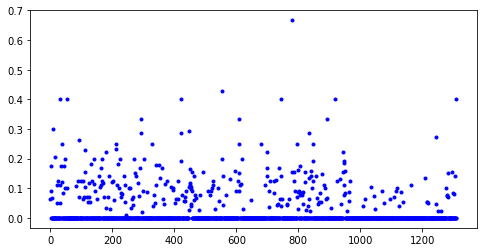

In [26]:
fig,ax = plt.subplots(figsize=(8,4))
_=ax.plot(range(1311),a2[:,1],'b.')

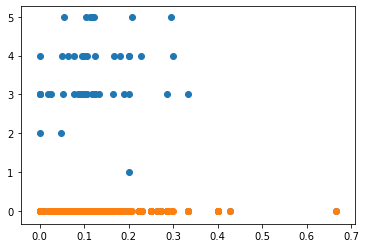

In [27]:
plt.figure()
plt.scatter(x=x_train[:,1],y= y_train[:,1])          
plt.scatter(x=a2[:,1], y=y_test[0:1311,1])
plt.show()

### RESULTADOS

Se considera un buen modelo para la prediccion de los datos principalmente porque corrio segun 'y' (las puntuaciones por usuario a cada pelicula) y 'x' (los generos).

Aun asi, la mayoria de las predicciones fueron 0 ya que la mayoria de las instancias en x (generos) eran 0.

